In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [15]:
import numpy as np

import sys
sys.path.append('../scripts/')

from utils import *
from data_utils import *
from implementations import *
from implementation_variants import *
from plots import *

DATA_PATH = '../data/'

# 0 Load data

In [3]:
 # Load train data
y, x, ids = load_csv_data(path.join(DATA_PATH, 'train.csv'))

# Split into train and evaluation set
(x_train, y_train), (x_eval, y_eval) = train_eval_split(y, x, split_ratio=.7, seed=1)

print(f' # train samples: {len(y_train)}\n # eval samples: {len(y_eval)}')

num_dim = x_train.shape[1]

 # train samples: 175000
 # eval samples: 75000


# 1 Define feature transforms to test

`feature_transform_mostinfo` removes features with the lowest linear correlation with the target variable. These features were selected in the notebook `Data Exploration.ipynb`

In [6]:
LEAST_INFO = ['DER_mass_vis', 'DER_deltar_tau_lep','DER_pt_tot','PRI_tau_eta','PRI_tau_phi',
              'PRI_lep_pt','PRI_lep_eta','PRI_lep_phi','PRI_met','PRI_met_phi']

def feature_transform_mostinfo(x):
    # Generate feature mask
    feature_mask = generate_mask(LEAST_INFO)
    
    # Remove unwanted features
    x = x[:, feature_mask]
    
    return x

`feature_transform_imputejet` imputes undefined values (originally encoded as -999) for all columns which are expected to be undefined if `PRI-jet_num` $\leq 1$ see CERN Open Data [documentation](http://opendata.cern.ch/record/328).

In [4]:
JET_NOT_DEFINED = ['DER_lep_eta_centrality', 'DER_prodeta_jet_jet', 'DER_mass_jet_jet', 'DER_deltaeta_jet_jet', 
                      'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_subleading_pt']

def feature_transform_imputejet(x):
    feature_idx = generate_feature_idx(JET_NOT_DEFINED)
    for i in feature_idx:
        impute_val = np.mean(x[:, i][x[:, i] != -999.])
        x[:,i][x[:, i] == -999.] = impute_val
    
    return x

`feature_transform_polybasis` expands each feature with a polynomial basis up to the maximum degree given. Undefined value are always replaced with $-999$.

In [45]:
def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=1 up to j=degree."""
    if len(x.shape) == 1:
        x = np.expand_dims(x, axis=1)
    phi = np.hstack([x**i for i in range(1, degree+1)])

    return phi

def feature_transform_polybasis(x, degree=4):
    
    fx_list = []
    # Expand polynomial basis for DEFINED values
    for i in range(x.shape[1]):
        # Build poly basis
        fx_poly = build_poly(x[:, i], degree)
        # Replace undefined value with same value for all polys
        fx_poly[x[:, i] == -999.] = -999

        fx_list.append(fx_poly)

    fx = np.hstack(fx_list)
    
    return fx

In [48]:
labels = ['Raw', 'MostInfo', 'ImputeJet', 'ExpandPoly']

In [49]:
def compare_features_visualisation(acc_train, acc_test, labels, model):
    arr_train = acc_train.flatten()
    arr_test = acc_test.flatten()

    arr_features = np.concatenate([np.repeat(labels, acc_train.shape[1]), np.repeat(labels, acc_train.shape[1])])
    arr_labels = np.concatenate([np.repeat('Train', len(arr_train)), np.repeat('Test', len(arr_test))])
    arr_acc = np.concatenate([arr_train, arr_test])

    plt_data = pd.DataFrame({'Feature Set':arr_features, 'Accuracy':arr_acc, 'Set':arr_labels})

    fig, ax = plt.subplots(figsize=(8,3.5))
    ax = sns.boxplot(x='Feature Set', y='Accuracy', hue='Set', data=plt_data)
    ax.set(ylabel='$\mathtt{Accuracy}$', title=f'{model}');
    
    return fig

# 2 Least-Squares

In [34]:
def run_least_squares(y_train, x_train, y_eval, x_eval):
    # Standardise to training mean and s.d.
    x_train, mean_x, std_x = standardise(x_train)
    x_eval = standardise_to_fixed(x_eval, mean_x, std_x)
    
    # Run training
    w, loss = least_squares(y_train, x_train)

    # Get training accuracy
    acc_tr  = eval_model(y_train, x_train, w, thresh=0)

    # Get accuracy on evaluation set
    acc_te = eval_model(y_eval, x_eval, w, thresh=0)
    print(f'Test Accuracy: {acc_te}')
    
    return w, loss, acc_tr, acc_te

In [50]:
k_fold = 4

# Store train and test accuracy 
acc_train = np.empty((len(labels), k_fold), float)
acc_test = np.empty((len(labels), k_fold), float)

print('\nFeature Set: Raw')
fx_train = x_train

i = 0
k = 0
for train_split, test_split in k_fold_iter(y_train, fx_train, k_fold):
    # Run evaluation
    w, loss, acc_tr, acc_te = run_least_squares(train_split[1], train_split[0], 
                                                test_split[1], test_split[0])
    acc_train[i, k] = acc_tr
    acc_test[i, k] = acc_te

    k+=1

print('\nFeature Set: MostInfo')
fx_train = feature_transform_mostinfo(x_train)

i = 1
k = 0
for train_split, test_split in k_fold_iter(y_train, fx_train, k_fold):
    # Run evaluation
    w, loss, acc_tr, acc_te = run_least_squares(train_split[1], train_split[0], 
                                                test_split[1], test_split[0])
    acc_train[i, k] = acc_tr
    acc_test[i, k] = acc_te

    k+=1
        
print('\nFeature Set: ImputeJet')
fx_train = feature_transform_imputejet(x_train)

i = 2
k = 0
for train_split, test_split in k_fold_iter(y_train, fx_train, k_fold):
    # Run evaluation
    w, loss, acc_tr, acc_te = run_least_squares(train_split[1], train_split[0], 
                                                test_split[1], test_split[0])
    acc_train[i, k] = acc_tr
    acc_test[i, k] = acc_te

    k+=1
    

print('\nFeature Set: Poly')
fx_train = feature_transform_polybasis(x_train)

i = 3
k = 0
for train_split, test_split in k_fold_iter(y_train, fx_train, k_fold):
    # Run evaluation
    w, loss, acc_tr, acc_te = run_least_squares(train_split[1], train_split[0], 
                                                test_split[1], test_split[0])
    acc_train[i, k] = acc_tr
    acc_test[i, k] = acc_te

    k+=1


Feature Set: Raw
Test Accuracy: 0.7192914285714286
Test Accuracy: 0.7192457142857143
Test Accuracy: 0.7180342857142857
Test Accuracy: 0.7168

Feature Set: MostInfo
Test Accuracy: 0.7092342857142857
Test Accuracy: 0.7072457142857143
Test Accuracy: 0.7091657142857143
Test Accuracy: 0.7037714285714286

Feature Set: ImputeJet
Test Accuracy: 0.7192914285714286
Test Accuracy: 0.7192457142857143
Test Accuracy: 0.7180342857142857
Test Accuracy: 0.7168

Feature Set: Poly
Test Accuracy: 0.7415314285714286
Test Accuracy: 0.7404114285714286
Test Accuracy: 0.7414628571428571
Test Accuracy: 0.7408685714285714


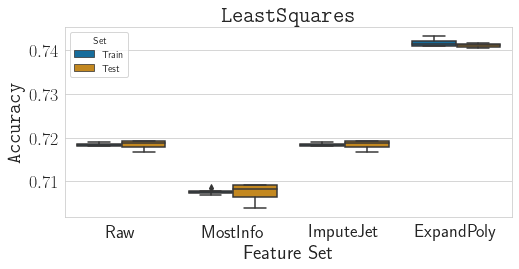

In [51]:
fig = compare_features_visualisation(acc_train, acc_test, labels, '$\mathtt{LeastSquares}$')
fig.savefig('../report/compare_features_ls.pdf', bbox_inches='tight')

# 3 Ridge Regresion

In [52]:
def run_ridge(y_train, x_train, y_eval, x_eval):
    # Standardise to training mean and s.d.
    x_train, mean_x, std_x = standardise(x_train)
    x_eval = standardise_to_fixed(x_eval, mean_x, std_x)
    
    lambdas = np.logspace(-8, -1, 10)
    k_fold = 4

    # Hyperparameter optimisation
    acc_train = np.empty((len(lambdas), k_fold), float)
    acc_test = np.empty((len(lambdas), k_fold), float)

    for l, lambda_ in enumerate(lambdas):
        k = 0
        for train_split, test_split in k_fold_iter(y_train, x_train, k_fold):
            # Train
            w, loss = ridge_regression(train_split[1], train_split[0], lambda_)
            acc_tr = eval_model(train_split[1], train_split[0], w)
            acc_train[l, k] = acc_tr

            # Test
            acc_te = eval_model(test_split[1], test_split[0], w)
            acc_test[l, k] = acc_te

            k += 1

    avg_acc_test = np.mean(acc_test, axis=1)
    lambda_opt_ridge = lambdas[np.argmax(avg_acc_test)]

    print('Maximum test accuracy {} with lambda {}'.format(np.max(avg_acc_test), lambda_opt_ridge))
    
    # Run training
    w, loss = ridge_regression(y_train, x_train, lambda_opt_ridge)

    acc_tr = eval_model(y_train, x_train, w)

    acc_te = eval_model(y_eval, x_eval, w)
    print(f'Test accuracy: {acc_te}')
    
    
    return w, loss, acc_tr, acc_te
    


Feature Set: Raw
Maximum test accuracy 0.7186395221260515 with lambda 0.0027825594022071257
Test accuracy: 0.7192457142857143
Maximum test accuracy 0.7177480799707425 with lambda 3.5938136638046254e-07
Test accuracy: 0.7192685714285715
Maximum test accuracy 0.7181366573204926 with lambda 1e-08
Test accuracy: 0.7179657142857143
Maximum test accuracy 0.7184947580153602 with lambda 2.1544346900318865e-06
Test accuracy: 0.7168685714285714

Feature Set: MostInfo
Maximum test accuracy 0.7086355601609168 with lambda 0.0027825594022071257
Test accuracy: 0.7104685714285714
Maximum test accuracy 0.708536511032549 with lambda 0.0027825594022071257
Test accuracy: 0.7077942857142857
Maximum test accuracy 0.7075231622577105 with lambda 0.0027825594022071257
Test accuracy: 0.7104914285714286
Maximum test accuracy 0.7091003291478728 with lambda 0.0027825594022071257
Test accuracy: 0.7056228571428571

Feature Set: ImputeJet
Maximum test accuracy 0.7186395221260515 with lambda 0.0027825594022071257
Tes

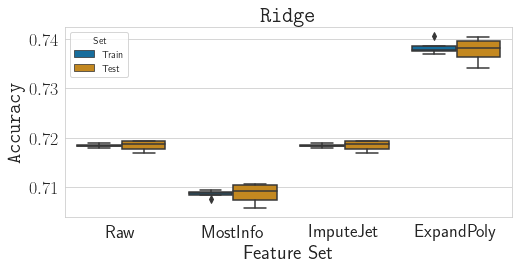

In [53]:
k_fold = 4

# Store train and test accuracy 
acc_train = np.empty((len(labels), k_fold), float)
acc_test = np.empty((len(labels), k_fold), float)

print('\nFeature Set: Raw')
fx_train = x_train

i = 0
k = 0
for train_split, test_split in k_fold_iter(y_train, fx_train, k_fold):
    # Run evaluation
    w, loss, acc_tr, acc_te = run_ridge(train_split[1], train_split[0], 
                                                test_split[1], test_split[0])
    acc_train[i, k] = acc_tr
    acc_test[i, k] = acc_te

    k+=1

print('\nFeature Set: MostInfo')
fx_train = feature_transform_mostinfo(x_train)

i = 1
k = 0
for train_split, test_split in k_fold_iter(y_train, fx_train, k_fold):
    # Run evaluation
    w, loss, acc_tr, acc_te = run_ridge(train_split[1], train_split[0], 
                                                test_split[1], test_split[0])
    acc_train[i, k] = acc_tr
    acc_test[i, k] = acc_te

    k+=1
        
print('\nFeature Set: ImputeJet')
fx_train = feature_transform_imputejet(x_train)

i = 2
k = 0
for train_split, test_split in k_fold_iter(y_train, fx_train, k_fold):
    # Run evaluation
    w, loss, acc_tr, acc_te = run_ridge(train_split[1], train_split[0], 
                                                test_split[1], test_split[0])
    acc_train[i, k] = acc_tr
    acc_test[i, k] = acc_te

    k+=1
    

print('\nFeature Set: Poly')
fx_train = feature_transform_polybasis(x_train)

i = 3
k = 0
for train_split, test_split in k_fold_iter(y_train, fx_train, k_fold):
    # Run evaluation
    w, loss, acc_tr, acc_te = run_ridge(train_split[1], train_split[0], 
                                                test_split[1], test_split[0])
    acc_train[i, k] = acc_tr
    acc_test[i, k] = acc_te

    k+=1
            
fig = compare_features_visualisation(acc_train, acc_test, labels, '$\mathtt{Ridge}$')
fig.savefig('../report/compare_features_ridge.pdf', bbox_inches='tight')

# 4 Logistic Regression

In [54]:
def run_logistic(y_train, x_train, y_eval, x_eval):
    # Standardise to training mean and s.d.
    x_train, mean_x, std_x = standardise(x_train)
    x_eval = standardise_to_fixed(x_eval, mean_x, std_x)

    tx_train = np.c_[np.ones(x_train.shape[0]), x_train]
    tx_eval = np.c_[np.ones(x_eval.shape[0]), x_eval]
    
    gamma = 0.01
    max_iters = 10000
    w_initial = np.ones(tx_train.shape[1])

    # Run gradient descent 
    w, loss = logistic_regression_mean(y_train, tx_train, w_initial, max_iters, gamma, threshold=1e-6)

    acc_tr = eval_model(y_train, tx_train, w, thresh=0.5)

    acc_te = eval_model(y_eval, tx_eval, w, thresh=0.5)
    print(f'Testing accuracy: {acc_te}')
    
    return w, loss, acc_tr, acc_te


Feature Set: Raw
Loss convergence:Terminate because loss did not change by more than threshold.
Testing accuracy: 0.7306971428571428
Loss convergence:Terminate because loss did not change by more than threshold.
Testing accuracy: 0.7277942857142857
Loss convergence:Terminate because loss did not change by more than threshold.
Testing accuracy: 0.7247085714285715
Loss convergence:Terminate because loss did not change by more than threshold.
Testing accuracy: 0.7246171428571428

Feature Set: MostInfo
Loss convergence:Terminate because loss did not change by more than threshold.
Testing accuracy: 0.71792
Loss convergence:Terminate because loss did not change by more than threshold.
Testing accuracy: 0.7134628571428572
Loss convergence:Terminate because loss did not change by more than threshold.
Testing accuracy: 0.7124114285714286
Loss convergence:Terminate because loss did not change by more than threshold.
Testing accuracy: 0.7127771428571429

Feature Set: ImputeJet
Loss convergence:T

../scripts/costs.py:49: RuntimeWarning: overflow encountered in exp
  return np.sum(np.log(1 + np.exp(z)) - y * z)
../scripts/implementation_variants.py:152: RuntimeWarning: invalid value encountered in double_scalars
  if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:


Testing accuracy: 0.7577142857142857
Testing accuracy: 0.7551542857142857
Testing accuracy: 0.7534171428571429
Testing accuracy: 0.7533028571428572


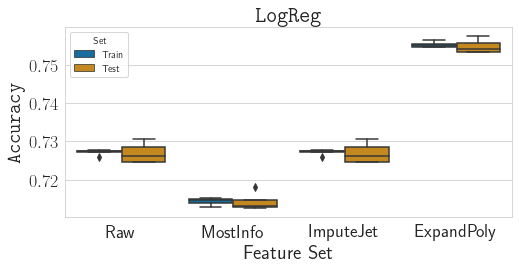

In [55]:
k_fold = 4

# Store train and test accuracy 
acc_train = np.empty((len(labels), k_fold), float)
acc_test = np.empty((len(labels), k_fold), float)

print('\nFeature Set: Raw')
fx_train = x_train

i = 0
k = 0
for train_split, test_split in k_fold_iter(y_train, fx_train, k_fold):
    # Run evaluation
    w, loss, acc_tr, acc_te = run_logistic(train_split[1], train_split[0], 
                                                test_split[1], test_split[0])
    acc_train[i, k] = acc_tr
    acc_test[i, k] = acc_te

    k+=1

print('\nFeature Set: MostInfo')
fx_train = feature_transform_mostinfo(x_train)

i = 1
k = 0
for train_split, test_split in k_fold_iter(y_train, fx_train, k_fold):
    # Run evaluation
    w, loss, acc_tr, acc_te = run_logistic(train_split[1], train_split[0], 
                                                test_split[1], test_split[0])
    acc_train[i, k] = acc_tr
    acc_test[i, k] = acc_te

    k+=1
        
print('\nFeature Set: ImputeJet')
fx_train = feature_transform_imputejet(x_train)

i = 2
k = 0
for train_split, test_split in k_fold_iter(y_train, fx_train, k_fold):
    # Run evaluation
    w, loss, acc_tr, acc_te = run_logistic(train_split[1], train_split[0], 
                                                test_split[1], test_split[0])
    acc_train[i, k] = acc_tr
    acc_test[i, k] = acc_te

    k+=1
    

print('\nFeature Set: Poly')
fx_train = feature_transform_polybasis(x_train)

i = 3
k = 0
for train_split, test_split in k_fold_iter(y_train, fx_train, k_fold):
    # Run evaluation
    w, loss, acc_tr, acc_te = run_logistic(train_split[1], train_split[0], 
                                                test_split[1], test_split[0])
    acc_train[i, k] = acc_tr
    acc_test[i, k] = acc_te

    k+=1
            
fig = compare_features_visualisation(acc_train, acc_test, labels, '$\mathtt{LogReg}$')
fig.savefig('../report/compare_features_logreg.pdf', bbox_inches='tight')

# 5 Compare model performance on best performing feature set 

##### Data Processing

In [56]:
fx_train = feature_transform_polybasis(x_train)
fx_eval = feature_transform_polybasis(x_eval)

fx_train, mean_fx, std_fx = standardise(fx_train)
fx_eval = standardise_to_fixed(fx_eval, mean_fx, std_fx)

tx_train = np.c_[np.ones(fx_train.shape[0]), fx_train]
tx_eval = np.c_[np.ones(fx_eval.shape[0]), fx_eval]

##### Baseline

In [57]:
# Get baseline frequency of the two classes in training data
prior_probs = [sum(y_train == 1)/len(y_train), sum(y_train == 0)/len(y_train)]

# Test error on evaluation set
y_eval_pred = np.random.choice([1., 0], size=len(y_eval), p=prior_probs)

acc_baseline = get_accuracy(y_eval_pred, y_eval)

print(f'Testing Accuracy: {acc_baseline}')

Testing Accuracy: 0.5495733333333334


##### LeastSquares

In [58]:
# Get linear least-squares model
w_ls, loss_ls = least_squares(y_train, fx_train)
print(f'Training loss: {loss_ls}')

# Get training accuracy
acc_tr  = eval_model(y_train, fx_train, w_ls, thresh=0)
print(f'Training accuracy: {acc_tr}')

# Get accuracy on evaluation set
acc_ls = eval_model(y_eval, fx_eval, w_ls, thresh=0)
print(f'Test Accuracy: {acc_ls}')

Training loss: 0.13507315799556574
Training accuracy: 0.7412857142857143
Test Accuracy: 0.7017466666666666


##### Train Ridge

In [59]:
# Run cross val
lambdas = np.logspace(-9, 0, 20)
k_fold = 4

# Hyperparameter optimisation
acc_train = np.empty((len(lambdas), k_fold), float)
acc_test = np.empty((len(lambdas), k_fold), float)

for l, lambda_ in enumerate(lambdas):
    print(f'lambda: {lambda_}')
    k = 0
    for train_split, test_split in k_fold_iter(y_train, fx_train, k_fold):
        # Train
        w, loss = ridge_regression(train_split[1], train_split[0], lambda_)
        acc_tr = eval_model(train_split[1], train_split[0], w)
        acc_train[l, k] = acc_tr

        # Test
        acc_te = eval_model(test_split[1], test_split[0], w)
        acc_test[l, k] = acc_te

        k += 1

lambda: 1e-09
lambda: 2.9763514416313133e-09
lambda: 8.858667904100832e-09
lambda: 2.6366508987303555e-08
lambda: 7.847599703514607e-08
lambda: 2.3357214690901212e-07
lambda: 6.951927961775605e-07
lambda: 2.06913808111479e-06
lambda: 6.158482110660255e-06
lambda: 1.8329807108324338e-05
lambda: 5.4555947811685143e-05
lambda: 0.0001623776739188721
lambda: 0.0004832930238571752
lambda: 0.0014384498882876629
lambda: 0.004281332398719387
lambda: 0.012742749857031322
lambda: 0.03792690190732246
lambda: 0.11288378916846883
lambda: 0.33598182862837744
lambda: 1.0


Maximum test accuracy 0.7355485714285714 with lambda 0.0004832930238571752


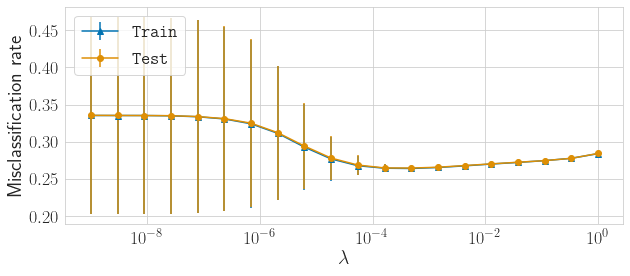

In [60]:
fig = cross_validation_visualization(lambdas, 1-acc_train, 1-acc_test)

avg_acc_test = np.mean(acc_test, axis=1)
lambda_opt_ridge = lambdas[np.argmax(avg_acc_test)]

print('Maximum test accuracy {} with lambda {}'.format(np.max(avg_acc_test), lambda_opt_ridge))

fig.savefig('../report/ridge_crossval.pdf', bbox_inches='tight')

In [61]:
# Run training
w_ridge, loss_ridge = ridge_regression(y_train, fx_train, lambda_opt_ridge)
print(f'Training loss: {loss_ridge}')

acc = eval_model(y_train, fx_train, w_ridge)
print(f'Training accuracy: {acc}')

acc_ridge = eval_model(y_eval, fx_eval, w_ridge)
print(f'Test accuracy: {acc_ridge}')

Training loss: 0.13594442402363963
Training accuracy: 0.7369542857142857
Test accuracy: 0.70048


##### Train LogReg

In [ ]:
# Run cross-validation to find optimal step-size
gammas = np.logspace(-7, -1, 5)
k_fold = 4

max_iters = 5000
w_initial = np.zeros(tx_train.shape[1])

# Hyperparameter optimisation
acc_train = np.empty((len(gammas), k_fold), float)
acc_test = np.empty((len(gammas), k_fold), float)

for g, gamma in enumerate(gammas):
    k = 0
    for train_split, test_split in k_fold_iter(y_train, tx_train, k_fold):
        # Train
        w, loss = logistic_regression_mean(train_split[1], train_split[0], w_initial, 
                                           max_iters, gamma, threshold=1e-6, verbose=False)
        
        acc_tr = eval_model(train_split[1], train_split[0], w, thresh=0.5)
        acc_train[g, k] = acc_tr

        # Test
        acc_te = eval_model(test_split[1], test_split[0], w, thresh=0.5)
        acc_test[g, k] = acc_te

        k += 1

Maximum test accuracy 0.7230571428571428 with gamma 0.01


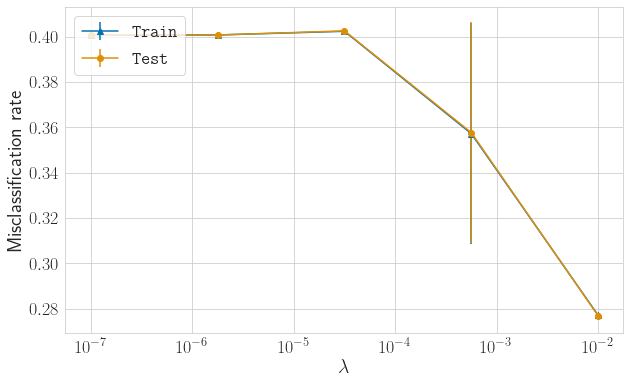

In [181]:
fig = cross_validation_visualization(gammas, 1-acc_train, 1-acc_test)
fig.savefig('../report/crossval_lr.pdf', bbox_inches='tight')
avg_acc_test = np.mean(acc_test, axis=1)
gamma_opt_lr = gammas[np.argmax(avg_acc_test)]

print('Maximum test accuracy {} with gamma {}'.format(np.max(avg_acc_test), gamma_opt_lr))

In [ ]:
max_iters = 15000
w_initial = np.zeros(tx_train.shape[1])

# Run gradient descent 
w_lr, loss_lr = logistic_regression_mean(y_train, tx_train, w_initial, max_iters, gamma_opt_lr, 
                                    threshold=1e-7, verbose=True)
print(f'Training loss: {loss_lr}')

acc = eval_model(y_train, tx_train, w_lr, thresh=0.5)
print(f'Training accuracy: {acc}')

acc_lr = eval_model(y_eval, tx_eval, w_lr, thresh=0.5)
print(f'Testing accuracy: {acc_lr}')

Gradient Descent (0/14999): loss=0.6895007360657128, gradient=0.6084223990299961
Gradient Descent (100/14999): loss=0.5838132631611054, gradient=0.20969821015110743
Gradient Descent (200/14999): loss=0.5538412238487147, gradient=0.1449446746323065
Gradient Descent (300/14999): loss=0.5375199179397461, gradient=0.11338004421997025
Gradient Descent (400/14999): loss=0.5269008836277951, gradient=0.0940440916288098
Gradient Descent (500/14999): loss=0.5193360900277314, gradient=0.08063832041172769
Gradient Descent (600/14999): loss=0.5136624896142911, gradient=0.0705010355387076
Gradient Descent (700/14999): loss=0.5092519115952263, gradient=0.06266691638284683
Gradient Descent (800/14999): loss=0.5057249205981087, gradient=0.05637169927326273
Gradient Descent (900/14999): loss=0.5028385296535001, gradient=0.05129925197216875
Gradient Descent (1000/14999): loss=0.5004216577493653, gradient=0.04719651982646345
Gradient Descent (1100/14999): loss=0.49835670990294745, gradient=0.0438218456017

#### Compare model performance 

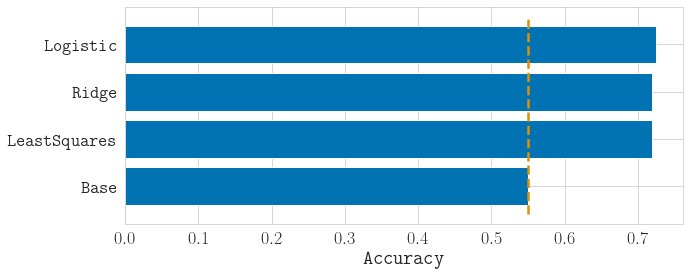

In [204]:
accuracy = [acc_baseline, acc_ls, acc_ridge, acc_lr]
labels = ['$\mathtt{Base}$', '$\mathtt{LeastSquares}$', '$\mathtt{Ridge}$',  
          '$\mathtt{Logistic}$']

fig = model_comparison_visualization(accuracy, labels, acc_baseline)
fig.savefig('../report/model_comparison_basic.pdf', bbox_inches='tight')

# 7 Final training and test set prediction 

In [216]:
# Load train data
y_train, x_train, _ = load_csv_data(path.join(DATA_PATH, 'train.csv'))

# Apply feature transform
fx_train = feature_transform_polybasis(x_train)

# Standardise to mean and s.d.
fx_train, mu_train, sigma_train = standardise(fx_train)

# Add offset term
tx_train = np.c_[np.ones(len(y_train)), fx_train]

In [219]:
max_iters = 50000
w_initial = np.ones(tx.shape[1])

# Run gradient descent 
w, loss = logistic_regression_mean(y, tx, w_initial, max_iters, gamma_opt_lr, 
                                    threshold=1e-7, verbose=True)
print(f'Training loss: {loss}')

acc = eval_model(y, tx, w, thresh=0.5)
print(f'Training accuracy: {acc}')

Gradient Descent (0/49999): loss=4.937179834027508, gradient=1.1057032757809109
Gradient Descent (100/49999): loss=3.744651344356511, gradient=1.074530152458014
Gradient Descent (200/49999): loss=2.6625209561537275, gradient=0.9930436773298132
Gradient Descent (300/49999): loss=1.8391322601491726, gradient=0.8008420436238565
Gradient Descent (400/49999): loss=1.3759000604068077, gradient=0.5674103365634904
Gradient Descent (500/49999): loss=1.1298178639043017, gradient=0.4425791156981762
Gradient Descent (600/49999): loss=0.9614391836172442, gradient=0.3823393411947238
Gradient Descent (700/49999): loss=0.8341217604025565, gradient=0.3316461954351393
Gradient Descent (800/49999): loss=0.7400726067579017, gradient=0.28212048731935746
Gradient Descent (900/49999): loss=0.6731399833234895, gradient=0.23613549073400175
Gradient Descent (1000/49999): loss=0.6266968086927045, gradient=0.19592817035617188
Gradient Descent (1100/49999): loss=0.5948062093381714, gradient=0.16230632570947698
Gra

Gradient Descent (9700/49999): loss=0.5008996032135524, gradient=0.008120654879063261
Gradient Descent (9800/49999): loss=0.5008343606321438, gradient=0.008035314547661298
Gradient Descent (9900/49999): loss=0.5007704802969359, gradient=0.00795109463439915
Gradient Descent (10000/49999): loss=0.5007079302825467, gradient=0.007867974302213395
Gradient Descent (10100/49999): loss=0.500646679541642, gradient=0.00778593336224445
Gradient Descent (10200/49999): loss=0.500586697874406, gradient=0.0077049522405518685
Gradient Descent (10300/49999): loss=0.5005279558994524, gradient=0.007625011947143799
Gradient Descent (10400/49999): loss=0.5004704250260839, gradient=0.007546094047131525
Gradient Descent (10500/49999): loss=0.5004140774278208, gradient=0.007468180633837798
Gradient Descent (10600/49999): loss=0.500358886017114, gradient=0.007391254303702702
Gradient Descent (10700/49999): loss=0.5003048244211744, gradient=0.0073152981328452275
Gradient Descent (10800/49999): loss=0.5002518669

Gradient Descent (19100/49999): loss=0.498108940458106, gradient=0.0032745659057052093
Gradient Descent (19200/49999): loss=0.4980983147453938, gradient=0.0032453219576341254
Gradient Descent (19300/49999): loss=0.4980878778515619, gradient=0.00321637640014441
Gradient Descent (19400/49999): loss=0.4980776261846476, gradient=0.003187725710026665
Loss convergence:Terminate because loss did not change by more than threshold.
Training loss: 0.4980685551438945
Training accuracy: 0.726596


In [220]:
# Load test data
y_test, x_test, ids_test = load_csv_data(path.join(DATA_PATH, 'test.csv'))
fx_test = feature_transform(x_test)

# Standardise to mean and s.d. of training data
fx_test = standardise_to_fixed(fx_test, mu_x, sigma_x)

# Add offset term
tx_test = np.c_[np.ones(fx_test.shape[0]), fx_test]

In [221]:
# Get predictions on test set
y_pred = predict_labels(w, tx_test, thresh=0.5)
create_csv_submission(ids_test, y_pred, '../data/final_submission.csv')